In [52]:
import numpy as np
import pandas as pd
from sklearn import datasets as ds
from matplotlib import pyplot as plt

In [2]:
class Dasso():
    def __init__(self, eps=1e-09, verbose=False):
        self.eps = eps
        self.verbose = verbose
        self.betas = []
        
    def fit(self, X, y):
        def c(X, y, beta):
            return np.matmul(X.T, (y - np.matmul(X, beta)))

        def max_covariate_indices(c):
            max_covariate = np.max(np.abs(c))
            return list(np.argwhere(np.abs(c) > (max_covariate - self.eps)).flatten())

        # Also see http://statweb.stanford.edu/~tibs/ftp/lars.pdf, page 7
        # Step 2: Let mathcal A be the active set indexing the covariances in c that are 
        # maximal in absolute value (within numerical error)
        def update_mathcal_A(mathcal_A_curr, c):
            mci = max_covariate_indices(c)
            for idx in mathcal_A_curr:
                if idx not in mci:
                    mathcal_A_curr.remove(idx)
            for idx in mci:
                if idx not in mathcal_A_curr:
                    mathcal_A_curr.append(idx)

        def non_zero_coefficients(beta):
            return list(np.argwhere(np.abs(beta) > self.eps).flatten())

        # Step 2: Let mathcal_B be the set indexing the non-zero coefficients of beta
        def update_mathcal_B(mathcal_B_curr, beta):
            nzc = non_zero_coefficients(beta)
            for idx in mathcal_B_curr:
                if idx not in nzc:
                    mathcal_B_curr.remove(idx)
            for idx in nzc:
                if idx not in mathcal_B_curr:
                    mathcal_B_curr.append(idx)
            # No op at the end as Python lists are mutable


        # Step 3.1
        # Let sA be the vector containing the signs of those covariances
        def s_mathcal_A(c, mathcal_A):
            return np.sign(c[mathcal_A])

        # write SA for the diagonal matrix whose diagonal is given by sA
        def S_mathcal_A(c, mathcal_A):
            return np.diag(s_mathcal_A(c, mathcal_A))

        # X with the columns which indices given by mathcal
        def X_mathcal(X, mathcal):
            return X[:, mathcal]

        # S_mathcal_A * (X_mathcal_A)^T * X 
        def SAXATX(X, c, mathcal_A):
            SA = S_mathcal_A(c, mathcal_A)
            XAT = X_mathcal(X, mathcal_A).T

            return np.matmul(np.matmul(SA, XAT), X)

        # Step 3.2
        # Write β+ for the positive part of β
        def beta_plus(beta):
            return np.maximum(beta, 0)

        # Write β− for the negative part of β
        def beta_minus(beta):
            return np.minimum(beta, 0)

        # compute the |mathcal_A| × 2p+|mathcal_A| matrix A=(-SAXTAX SAXTAX I), 
        # where I is the identity matrix
        def A(X, c, mathcal_A):
            A = -1 * SAXATX(X, c, mathcal_A)
            A = np.append(A, SAXATX(X, c, mathcal_A), axis=1)
            A = np.append(A, np.identity(len(mathcal_A)), axis=1)

            return A

        def q(A, B_1, B_2):
            # The row dimension of A is |mathcal_A|
            dim_mathcal_A = A.shape[0]

            return [A[(dim_mathcal_A - 1), i] -
                    np.matmul(np.matmul(B_2, np.linalg.inv(B_1)), 
                              A[0:(dim_mathcal_A - 1), i])
                    for i in range(0, A.shape[1])]

        def alpha(B_1, B_2):
            # The row dimension of B_1 is |mathcal_A| - 1
            dim_mathcal_A = B_1.shape[0] + 1

            return np.matmul(np.matmul(B_2, np.linalg.inv(B_1)), 
                             np.ones((dim_mathcal_A - 1, 1))) - 1

        def i_star(A, B_tilde):
            dim_mathcal_A = A.shape[0]
            dim_p = (A.shape[1] - dim_mathcal_A) / 2
            assert (dim_p.is_integer())
            assert (B_tilde.shape[1] == (dim_mathcal_A - 1))

            B_1 = B_tilde[0:(dim_mathcal_A - 1), :]
            B_2 = B_tilde[dim_mathcal_A - 1, :]

            _q = q(A, B_1, B_2)
            _alpha = alpha(B_1, B_2)

            vals = [
                (np.matmul(np.matmul(np.ones(dim_mathcal_A - 1), np.linalg.inv(B_1)),
                           A[0:(dim_mathcal_A - 1), i]) - 
                 (1 if i < (2 * dim_p) else 0)
                ) / np.abs(_q[i])
                if ((np.abs(_q[i]) > self.eps) and ((_alpha / _q[i]) > self.eps)) else -np.inf
                for i in range(0, A.shape[1])
            ]

            max_val = np.max(vals)
            return(np.argwhere(vals >= (max_val - self.eps)).flatten()[0])

        # Use the new mathcal_A and mathcal_B to calculate the |mathcal_B|-dimensional
        # direction vector h_mathcal_B =((X_mathcal_A)^T * X_mathcal_B)^(−1) * s_mathcal_A. 
        def h_mathcal_B(X, c, mathcal_A, mathcal_B):
            return np.matmul(
                np.linalg.inv(np.matmul(X_mathcal(X, mathcal_A).T, 
                                        X_mathcal(X, mathcal_B))),
                s_mathcal_A(c, mathcal_A))

        # Let h be the p-dimensional vector with the components corresponding to 
        # mathcal_B given by h_mathcal_B and the remainder set to 0.
        def h(X, c, mathcal_A, mathcal_B):
            dim_p = X.shape[1]
            _h_mathcal_B = h_mathcal_B(X, c, mathcal_A, mathcal_B)

            _h = np.zeros(dim_p)
            for mathcal_B_idx, h_idx in enumerate(mathcal_B, start=0):
                _h[h_idx] = _h_mathcal_B[mathcal_B_idx]

            return _h

        # The first occurs at the point where a new variable enters the active set mathcal_A.
        def gamma_1(X, c, h, mathcal_A):
            dim_p = X.shape[1]
            mathcal_A_comp = np.setdiff1d(range(0, X.shape[1]), mathcal_A)
            
            # LARS paper P.416, lines 6-8: The exception is at the last stage: since Am contains all covariates, 
            # (2.13) is not defined.
            if len(mathcal_A_comp) == 0:
                return(np.max(np.abs(c)))
            # TODO: A_m is missing here
            
            else:
                vals = np.array([
                    (c[k] - c[j]) /
                    np.matmul(np.matmul((X[:, k] - X[:, j]).T, X), h)
                    if np.abs(np.matmul(np.matmul((X[:, k] - X[:, j]).T, X), h)) > self.eps else 0
                    for k in mathcal_A for j in mathcal_A_comp
                ])

                vals = np.append(
                    vals, 
                    np.array([
                        (c[k] + c[j]) /
                        np.matmul(np.matmul((X[:, k] + X[:, j]).T, X), h)
                        if np.abs(np.matmul(np.matmul((X[:, k] + X[:, j]).T, X), h)) > self.eps else 0
                        for k in mathcal_A for j in mathcal_A_comp])
                )

                # min+ is the minimum taken over the positive components only
                return (np.min([val if val > self.eps else np.inf for val in vals]) 
                        if len(vals) > 0 else np.inf)

        # The second possible break in the path occurs if a coefficient path crosses zero, 
        # i.e. β_j + γ*h_j =0. It is easily verified that the corresponding distance is 
        # given by γ_2 = min+_j {−β_j/h_j}. 
        def gamma_2(beta, h):
            # Assuming they mean all j, not j in mathcal_(A^comp)
            vals = np.array([
                (-beta[j] / h[j]) if (np.abs(h[j]) > self.eps) else 0
                for j in range(0, h.shape[0])
            ])

            # min+ is the minimum taken over the positive components only
            return np.min([val if val > self.eps else np.inf for val in vals])

        def gamma(X, beta, c, h, mathcal_A):
            return min(gamma_1(X, c, h, mathcal_A),
                       gamma_2(beta, h))

        self.betas = []
        dim_n = X.shape[0]
        dim_p = X.shape[1]

        # Step 1
        beta = np.zeros(dim_p)
        self.betas.append(beta)
        l = 1
        mathcal_A = []
        mathcal_B = []
        
        while True:
            # Step 2
            update_mathcal_B(mathcal_B, beta)

            _c = c(X, y, beta)
            update_mathcal_A(mathcal_A, _c)

            sA = s_mathcal_A(_c, mathcal_A)
            
            assert len(mathcal_A) == (len(mathcal_B) + 1)

            # Step 3
            if (len(mathcal_B) == 0):
                mathcal_B.append(max_covariate_indices(_c)[0])
            else:
                # Appendix 1, step 1
                _A = A(X, _c, mathcal_A)

                # Appendix 1, step 2
                B_tilde = _A[:, np.concatenate(
                    (np.argwhere(np.abs(beta_plus(beta)) > self.eps).flatten(),
                     dim_p + np.argwhere(np.abs(beta_minus(beta)) > self.eps).flatten()))]
                _i_star = i_star(_A, B_tilde)

                # Appendix 1, step 3
                if _i_star < (2 * dim_p):
                    if (_i_star % dim_p) not in mathcal_B:
                        mathcal_B.append(_i_star % dim_p)
                else:
                    del mathcal_A[(_i_star - 2 * dim_p)]

            assert len(mathcal_A) == len(mathcal_B)

            _h = h(X, _c, mathcal_A, mathcal_B)

            # Step 4
            _gamma = gamma(X, beta, _c, _h, mathcal_A)

            beta = beta + _gamma * _h
            self.betas.append(beta)

            # Step 5
            max_covar = np.abs(np.max(c(X, y, beta)))
            if max_covar < self.eps:
                break

            if (l % 10 == 0) and self.verbose:
                print("Iteration {}: ||c||_inf = {}".format(l, max_covar),
                      end="\r")
            l += 1

        print("Iteration {}: ||c||_inf = {}".format(l, max_covar), end="\r")
        
    def get_params(self, deep=True):
        params = {'betas': self.betas,
                  'beta': self.betas[-1]}
        return params

# Random data

In [190]:
dim_n = 72
dim_p = 256
dim_s = 8

X = np.random.normal(0, 1, (dim_n, dim_p))
X = X - np.mean(X, axis=0)
X = X / np.sqrt(np.sum(X**2, axis=0))

beta_true = np.zeros(dim_p)
for i in np.random.choice(range(0, dim_p), dim_s, replace=False):
    # First bit is the sign, second bit is the value
    beta_true[i] = (np.random.randint(2) * 2 - 1) * np.random.gamma(10, 0.12)

Y = np.matmul(X, beta_true) + np.random.normal(0, 1/3 * np.sqrt(dim_s/dim_n), dim_n)

In [191]:
# DASSO algorithm
dasso_random = Dasso(verbose=True)
dasso_random.fit(X, Y)

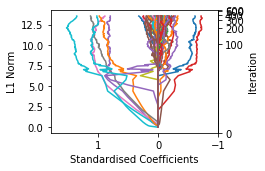

In [194]:
betas_random = dasso_random.get_params()['betas']

def norm_to_index(x):
    return np.interp(x, np.linalg.norm(betas_random, 1, 1), range(0, len(betas_random)))

def index_to_norm(x):
    return np.interp(x, range(0, len(betas_random)), np.linalg.norm(betas_random, 1, 1))

fig, ax1 = plt.subplots(1, figsize=(3, 2.25))

ax1.plot(betas_random, np.linalg.norm(betas_random, 1, 1))
ax1.set_xlim(1.8, -1)
ax1.set_ylabel("L1 Norm")
ax1.set_xlabel("Standardised Coefficients")

ax2 = ax1.secondary_yaxis('right', functions=(norm_to_index, index_to_norm))
ax2.set_ylabel('Iteration')

fig.savefig('../coefficient_paths_random.pdf', 
            bbox_inches='tight', transparent=True)

# Diabetes data

In [100]:
X_diabetes, y_diabetes = ds.load_diabetes(return_X_y=True)
y_diabetes = y_diabetes - y_diabetes.mean() 

In [101]:
# DASSO algorithm
dasso_diabetes = Dasso(eps=1e-11, verbose=True)
dasso_diabetes.fit(X_diabetes, y_diabetes)

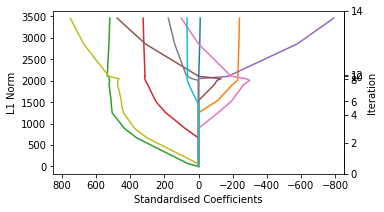

In [200]:
betas_diabetes = dasso_diabetes.get_params()['betas']

def norm_to_index(x):
    return np.interp(x, np.linalg.norm(betas_diabetes, 1, 1), range(0, len(betas_diabetes)))

def index_to_norm(x):
    return np.interp(x, range(0, len(betas_diabetes)), np.linalg.norm(betas_diabetes, 1, 1))

fig, ax1 = plt.subplots(1, figsize=(5.2, 3))

ax1.plot(betas_diabetes, np.linalg.norm(betas_diabetes, 1, 1))
ax1.set_xlim(850, -850)
ax1.set_ylabel("L1 Norm")
ax1.set_xlabel("Standardised Coefficients")

ax2 = ax1.secondary_yaxis('right', functions=(norm_to_index, index_to_norm))
ax2.set_ylabel('Iteration')

fig.savefig('../coefficient_paths_diabetes.pdf', 
            bbox_inches='tight', transparent=True)

# Boston Housing Data

In [103]:
X_boston, y_boston = ds.load_boston(return_X_y=True)
y_boston = y_boston - y_boston.mean()
X_boston = X_boston - np.mean(X_boston, axis=0)
X_boston = X_boston / np.sqrt(np.sum(X_boston**2, axis=0))

In [104]:
dasso_boston = Dasso(eps=5e-13, verbose=True)
dasso_boston.fit(X_boston, y_boston)

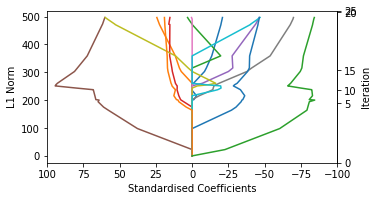

In [202]:
betas_boston = dasso_boston.get_params()['betas']

def norm_to_index(x):
    return np.interp(x, np.linalg.norm(betas_boston, 1, 1), range(0, len(betas_boston)))

def index_to_norm(x):
    return np.interp(x, range(0, len(betas_boston)), np.linalg.norm(betas_boston, 1, 1))

fig, ax1 = plt.subplots(1, figsize=(5.2, 2.8))

ax1.plot(betas_boston, np.linalg.norm(betas_boston, 1, 1))
ax1.set_xlim(100, -100)
ax1.set_ylabel("L1 Norm")
ax1.set_xlabel("Standardised Coefficients")

ax2 = ax1.secondary_yaxis('right', functions=(norm_to_index, index_to_norm))
ax2.set_ylabel('Iteration')

fig.savefig('../coefficient_paths_boston.pdf', 
            bbox_inches='tight', transparent=True)